In [1]:
# import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
%matplotlib inline

In [2]:
# load sota basin shapefile
sota = gpd.read_file('./data/input/sota_basin.shp')

In [3]:
# load sota sub basins shapefile
subs = gpd.read_file('./data/input/sub_basins_sota.shp')

In [4]:
# find minimum and maximum elevation of each sub basin
subs = subs.join(pd.DataFrame(zonal_stats(
    vectors=subs['geometry'],
    raster='./data/input/dem_sota.tif',
    stats=['max','min'])), how='left')

In [5]:
# calculate height difference
subs['D'] = subs['max'] - subs['min']

In [6]:
# calculate perimeter and area
subs['P'] = subs.length
subs['A'] = subs.area

In [7]:
# calculate shape coefficient
subs['C'] = 0.282 * subs['P'] * (subs['A'] ** -0.5)

In [8]:
# calculate equivalent rectangle length
subs ['L'] = (subs['A'] ** 0.5) * (subs['C'] / 1.128) * (1 + np.sqrt(1 - ((1.128 / subs['C']) ** 2)))

In [9]:
# calculate specific height difference
subs['Ds'] = (subs['D'] / subs['L']) * (subs['A'] ** 0.5)

In [10]:
# classify relief by specific height difference
subs.loc[subs['Ds'] < 10, 'relief'] = 'R1'
subs.loc[(10 < subs['Ds']) & (subs['Ds'] < 25), 'relief'] = 'R2'
subs.loc[(25 < subs['Ds']) & (subs['Ds'] < 50), 'relief'] = 'R3'
subs.loc[(50 < subs['Ds']) & (subs['Ds'] < 100), 'relief'] = 'R4'
subs.loc[(100 < subs['Ds']) & (subs['Ds'] < 250), 'relief'] = 'R5'
subs.loc[(250 < subs['Ds']) & (subs['Ds'] < 500), 'relief'] = 'R6'
subs.loc[subs['Ds'] > 500, 'relief'] = 'R7'

In [11]:
# check relief classes in sota
subs['relief'].unique()

array(['R3', 'R4', 'R2'], dtype=object)

In [12]:
# create new dataframe of relif classes of sota
relief_sota_class = subs[['PolygonId', 'relief', 'geometry']].to_crs('EPSG:4326')

In [13]:
# categorize by sensibility of relief classes to water
r_conditions_ = [(relief_sota_class['relief'] == 'R2'),
                  (relief_sota_class['relief'] == 'R3'),
                  (relief_sota_class['relief'] == 'R4')
                 ]
r_choices_ = [3, 2, 1]
relief_sota_class['W_Type'] = np.select(r_conditions_, r_choices_, default=None)

In [14]:
# dissolve relief data with water type column
relief_sota_class = relief_sota_class.dissolve(by='W_Type').reset_index()

<AxesSubplot:>

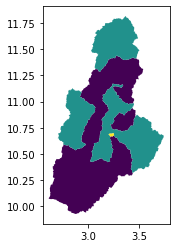

In [15]:
# plot categorized relief
relief_sota_class.plot(column='W_Type')

In [16]:
# export to homogeneous relief zones of sota
#relief_sota_class.to_file('./data/output/homogeneous_relief_zone.shp')